# How to Directly Access MERRA-2 Data from an S3 Bucket with Python
### Author: Chris Battisto
### Date Authored: 1-11-22

### Timing

Exercise: 30 minutes

<p></p>

<div style="background:#fc9090;border:1px solid #cccccc;padding:5px 10px;"><big><b>Note:  </b>Because this notebook uses the S3 protocol, <em><strong>it will only run in an environment with <a href="https://disc.gsfc.nasa.gov/information/glossary?keywords=%22earthdata%20cloud%22&amp;title=AWS%20region">us-west-2 AWS access</a></strong></em>.</big></div>

### Overview

This notebook demonstrates how to access and plot a Modern-Era Retrospective analysis for Research and Applications (MERRA-2) M2T1NXSLV.5.12.4 file hosted via an Amazon S3 bucket. It demonstrates how to access an S3 bucket with the S3FS library and then plot sea-level pressure contours of a single file with Cartopy and Matplotlib. 

### Prerequisites

This notebook was written using Python 3.8, and requires these libraries and files: 
- xarray
- cartopy
- matplotlib
- S3FS
  - S3FS documentation: https://s3fs.readthedocs.io/en/latest/install.html\
- Boto3
  - Boto3 documentation: https://boto3.amazonaws.com/v1/documentation/api/latest/index.html
- netrc file with valid Earthdata Login credentials.
- Approval to access the GES DISC archives with your Earthdata credentials (https://disc.gsfc.nasa.gov/earthdata-login)


### Import Libraries

In [1]:
import xarray as xr
import earthaccess
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline

### Check AWS Region before running notebook

A common error when executing this notebook occurs when the notebook is run outside of the us-west-2 AWS region. Here, we check the region using the Boto3 Python library, and throw a ValueError if you are outside the region.

This cell is not necessary to access the S3 buckets for users inside the us-west-2 region, and can be commented out or deleted at the users' discretion.

In [2]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')
    

### us-west-2 Region Check: &#x2705;

### Search for the Granule using `earthaccess`

In [3]:
# Authenticate using Earthdata Login prerequisite files
auth = earthaccess.login()

# Search for the granule by DOI
results = earthaccess.search_data(
    doi='10.5067/VJAFPLI1CSIV',
    temporal=("2019-03-13", "2019-03-13"),
)

Granules found: 1


### Open the Granule using `earthaccess` and `xarray`

In order to open an S3 bucket file, or group of files in Xarray, <code>fs.open()</code> and <code>fs.glob()</code> must be used when calling their URLs in <code>open_dataset()</code>.
Here, we open a single M2T1NXSLV.5.12.4 file and subset its sea-level pressure values at a particular time slice.

In [4]:
fn = earthaccess.open(results)

ds = xr.open_mfdataset(fn)

# Subset SLP at 15:30Z, convert units
slp = ds.SLP.values[15,:,:] / 100 # convert to hPa

slp

Opening 1 granules, approx size: 0.39 GB
using endpoint: https://data.gesdisc.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

array([[ 985.77765,  985.77765,  985.77765, ...,  985.77765,  985.77765,
         985.77765],
       [ 985.1326 ,  985.1326 ,  985.1326 , ...,  985.13763,  985.13763,
         985.1326 ],
       [ 983.9426 ,  983.9377 ,  983.9377 , ...,  983.95264,  983.94763,
         983.94763],
       ...,
       [1007.2477 , 1007.26013, 1007.27014, ..., 1007.21014, 1007.22266,
        1007.23517],
       [1007.67017, 1007.6752 , 1007.6777 , ..., 1007.65765, 1007.66266,
        1007.66516],
       [1007.97766, 1007.97766, 1007.97766, ..., 1007.97766, 1007.97766,
        1007.97766]], dtype=float32)

### Plot Sea-Level Pressure Contours

Now that the file is inside a local Xarray dataset, we can perform any data analysis methods desired, such as plotting with Matplotlib.

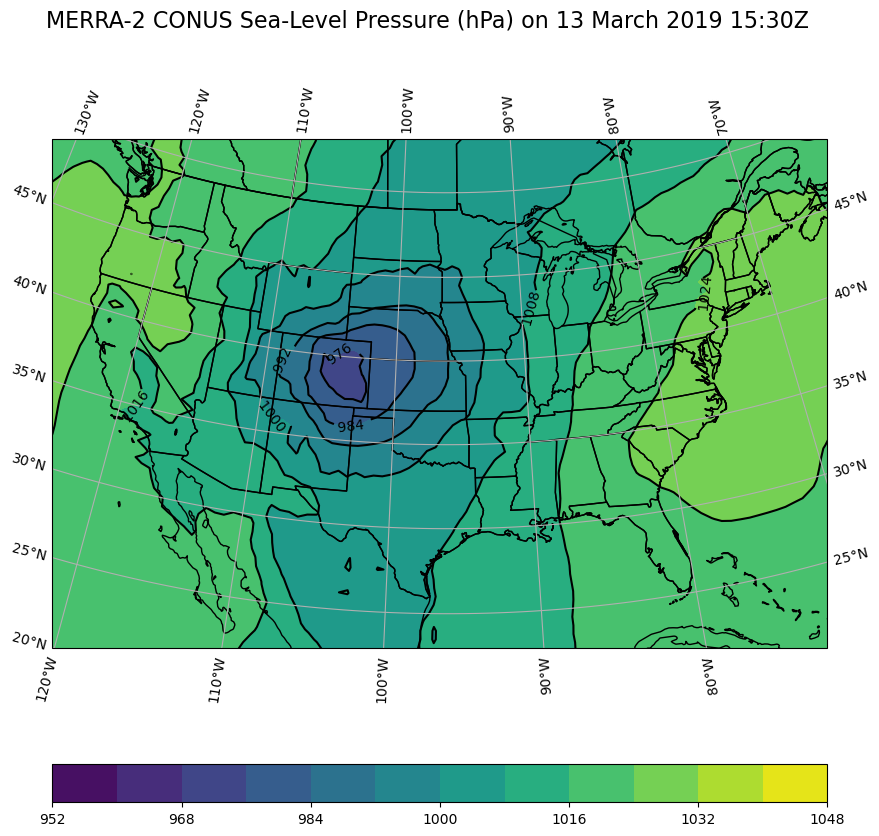

In [5]:
plt.rcParams['figure.figsize'] = 10,10

# Set up figure
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-121, -72, 23, 51], crs=ccrs.PlateCarree()) # CONUS extent
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

# Set up filled and line contours
filled_c = ax.contourf(ds.lon, ds.lat, slp, levels=10, 
                       transform=ccrs.PlateCarree())
line_c = ax.contour(ds.lon, ds.lat, slp, levels=10,
                        colors=['black'],
                        transform=ccrs.PlateCarree())

# Lat/lon grid lines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Set up labelling for contours
ax.clabel(line_c,  
    colors=['black'],
    manual=False,  
    inline=True,  
    fmt=' {:.0f} '.format,  
    )

# Set up colorbar and figure title
fig.colorbar(filled_c, orientation='horizontal')
fig.suptitle('MERRA-2 CONUS Sea-Level Pressure (hPa) on 13 March 2019 15:30Z', fontsize=16)

plt.show()